# "Single-Column" Input File Creation

Preparing matrix of 1D columns .nc file and formatting for input ecRad file (Useful for TripleClouds Solver).

Version 6: 2023-07-17

Fixed parameters:
1. Radiative Transfer Model: ecRad.
1. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
2. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
3. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
4. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
5. No gases and aerosols.
6. No liquid water.
7. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).

Variable parameters:
1. Macro: Position-Altitude-Temperature.
2. Macro: Geometrical Depth $\Delta h$ (0.5 km to 5 km every 0.25 km (Nellore, Kannan, Vellaisamy 2019)).
3. Macro: Ice Water Path (IWP) = 30 $g/m^2$ (Around Anvil Cirrus IWP typical value (Sokol & Hartmann 2020)):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz} \;=\; 30\;\frac{g}{m^2}\;\;\; , \;\;\;(h_2 - h_1 = \Delta h \;(km))$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/kg)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{30\;g/m^2}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
3. matplotlib : 3.6.2
4. scipy: 1.10.0

In [14]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy import interpolate

import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

### Tropical sounding

In [2]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_8819/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [3]:
temp            = tropical_profile['temperature (K)'].iloc[::-1]
height          = tropical_profile['height (km)'].iloc[::-1]
tropopause_i    = temp.argmin()
tropopause      = temp.iloc[tropopause_i]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]

print('Tropopause: ',tropopause,' K at ',height.iloc[tropopause_i],' km')
print('Melting Layer: ',height.iloc[melting_layer_i],' km')

Tropopause:  195.6  K at  17.0  km
Melting Layer:  4.75  km


### Density Profile $(kg/m^3)$

In [4]:
R = 287 # J/kgK
density_0 = (tropical_profile['pressure (hPa)']*100)/(tropical_profile['temperature (K)']*R)
density   = density_0.iloc[::-1]

Estimating Lapse Rate:

In [5]:
DT = tropical_profile['temperature (K)'][30] - tropical_profile['temperature (K)'][20]
Dh = tropical_profile['height (km)'][30] - tropical_profile['height (km)'][20]
slope = DT/Dh
print('Lapse Rate: ',slope,' K/km')

Lapse Rate:  -6.7  K/km


## Preparing input

List of parameters:

- Skin Temperature (for each temperature-perturbation level)
- cos_solar_zenith_angle (for each temperature-perturbation level)
- pressure_hl (half level column)
- temperature_hl (half level column)
- q or h2o_mmr (Specific Humidity) (level column)
- o3_mmr (Ozone Mass Mixing Ratio) (level column)
- q_liquid (Liquid cloud mass mixing ratio (kg kg-1)) (level column)
- q_ice (Ice cloud mass mixing ratio (kg kg-1)) (level column)
- re_liquid (m) (level column)
- re_ice (m) (level column)
- cloud_fraction (level column)
- sw_albedo (1 value)
- lw_emissivity (1 value)
- aerosol_mmr (matrix)

### 1. Half Level Pressures (Pa)

"The half_level dimension corresponds to the mid-points of the levels, plus the top-of-atmosphere and surface, and so must be one more than level"

In [6]:
pressure_hli = [tropical_profile['pressure (hPa)'].iloc[-1]*100] # Pa
for i in range(len(tropical_profile['pressure (hPa)'])-1):
    pif = tropical_profile['pressure (hPa)'].iloc[-1-(i+1)]*100
    pii = tropical_profile['pressure (hPa)'].iloc[-1-i]*100
    pressure_hli.append((pif+pii)/2)
pressure_hli.append(tropical_profile['pressure (hPa)'].iloc[0]*100) # Pa

### 2. Half Level Temperatures (K)

Interpolation obtained from half level pressures:

In [7]:
temp_int        = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                       tropical_profile['temperature (K)'].iloc[::-1])
temperature_hli = temp_int(pressure_hli)

### 3. Matrix

Level of perturbation:

In [8]:
upper_limit_i = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i = (temp.iloc[tropopause_i:] - 236).abs().argmin()
geom_depths   = np.arange(.5, 5.25, .25)
rows          = len(geom_depths)
temp_range    = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1].to_numpy()
height_range  = height.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1].to_numpy()

In [9]:
geom_depths

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

### 3.1 Geometrical Depth with fixed top level (15 km ~ 203.6 K)

In [10]:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # (K)

re = 30 # Effective radious (um)

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows, len(pressure_hli)-1), qi)

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows, len(pressure_hli)-1))

# Ice cloud mass mixing ratio (perturbations X level):
q_ice = np.zeros((rows, len(pressure_hli)-1))

cloud_fraction = np.zeros((rows, len(pressure_hli)-1))

# CREATING THE ICE CLOUD PROFILE:  
for i in range(rows): # rows with different geometrical depths ("column" dimension for final matrix)
    for j in range(len(height)): # columns with vertical profiles ("level" dimension for final matrix)
        hj = height.iloc[j]
        # Integration layer (for variable geometrical depth):
        # iloc position, NOT LOC (Be careful)
        lower_limit_h = height.index.get_loc(height[height == (15 - geom_depths[i])].index[0])
        upper_limit_h = height.index.get_loc(height[height == 15].index[0]) # fixed
        if hj >= (15 - geom_depths[i]) and hj <= 15:
            # Integral from top to bottom:
            integral = np.trapz(density.iloc[upper_limit_h:lower_limit_h+1],
                                height.iloc[upper_limit_h:lower_limit_h+1]*1000,0.1)
            q_ice[i,j] = (30/abs(integral))*1e-3 # qi = IWP / int(rho dz) kg/kg
            cloud_fraction[i,j] = 1
    
# Liquid cloud effective radius (m):
re_liquid = np.full((rows, len(pressure_hli)-1), 1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows, len(pressure_hli)-1), re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows, len(pressure_hli)), pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows, len(pressure_hli)), temperature_hli)

Checking:

In [11]:
lower_limit_h = height.index.get_loc(height[height == (15 - geom_depths[0])].index[0])
upper_limit_h = height.index.get_loc(height[height == 15].index[0]) # fixed

In [12]:
height.iloc[upper_limit_h:lower_limit_h+1]

60    15.00
59    14.75
58    14.50
Name: height (km), dtype: float64

<IPython.core.display.Javascript object>


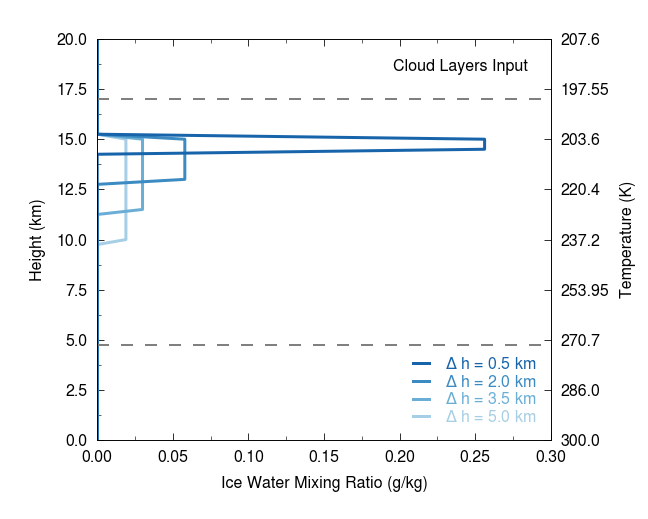

In [17]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']
length    = 9 # inches
heigth    = length*.8 # inches
f, ax     = plt.subplots(figsize = (length, heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.15, right = 0.85)


handles = []
labels  = []
counter = 0
for i in [0,6,12,-1][::-1]:        
    h = ax.plot(q_ice[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                 linestyle = 'solid', linewidth = 3,
                 color = matplotlib.cm.Blues(.35 + counter*.15), alpha = 1)
    handles = handles + h
    labels.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    counter += 1

melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h5 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h6 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel('Ice Water Mixing Ratio (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-1,1,.05)
minor_ticks_x = np.arange(-1,1,.025)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .3)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
legend  = plt.legend(handles[::-1], labels[::-1], loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .1, labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size':fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_gdepth_top_v6.png', dpi = 500)

#### Final Table

In [13]:
ds = xr.Dataset(
    data_vars = dict(
        #time = (time),
        depth = (['column'], geom_depths),
        #longitude = (['column'], longitude),
        lw_emissivity = (['column'], lw_emissivity),
        sw_albedo = (['column'], sw_albedo),
        skin_temperature = (['column'], skin_temperature),
        cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
        pressure_hl = (['column','half_level'], pressure_hl),
        temperature_hl = (['column','half_level'], temperature_hl),
        q = (['column','level'], q),
        o3_mmr = (['column','level'], o3_mmr),
        q_liquid = (['column','level'], q_liquid),
        q_ice = (['column','level'], q_ice),
        re_liquid = (['column','level'], re_liquid),
        re_ice = (['column','level'], re_ice),
        cloud_fraction = (['column','level'], cloud_fraction),
    ),
    attrs = dict(
        title="1D columns matrix input for ecRad"),
)

In [14]:
out_dir = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file    = 'input_1D_matrix_gdepth_top_v6.nc'
ds.to_netcdf(path = out_dir+file)

### 3.2 Geometrical Depth with fixed bottom level (10 km ~ 237.2 K)

In [18]:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # (K)

re = 30 # Effective radious (um)

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows, len(pressure_hli)-1), qi)

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows, len(pressure_hli)-1))

# Ice cloud mass mixing ratio (perturbations X level):
q_ice = np.zeros((rows, len(pressure_hli)-1))

cloud_fraction = np.zeros((rows, len(pressure_hli)-1))

# CREATING THE PROFILE     
for i in range(rows): # rows with different geometrical depths ("column" dimension for final matrix)
    for j in range(len(height)): # columns with vertical profiles ("level" dimension for final matrix)
        hj = height.iloc[j]
        lower_limit_h = height.index.get_loc(height[height == 10].index[0])
        upper_limit_h = height.index.get_loc(height[height == (10 + geom_depths[::-1][i])].index[0]) # fixed
        if hj >= 10 and hj <= (10 + geom_depths[::-1][i]):
            integral = np.trapz(density.iloc[upper_limit_h:lower_limit_h+1],
                                height.iloc[upper_limit_h:lower_limit_h+1]*1000,0.1)
            q_ice[i,j] = (30/abs(integral))*1e-3 # qi = IWP / int(rho dz) kg/kg
            cloud_fraction[i,j] = 1
    
# Liquid cloud effective radius (m):
re_liquid = np.full((rows, len(pressure_hli)-1), 1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows, len(pressure_hli)-1), re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows, len(pressure_hli)), pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows, len(pressure_hli)), temperature_hli)

Checking:

In [19]:
lower_limit_h = height.index.get_loc(height[height == 10].index[0])
upper_limit_h = height.index.get_loc(height[height == (10 + geom_depths[::-1][0])].index[0]) # fixed

In [20]:
height.iloc[upper_limit_h:lower_limit_h+1]

60    15.00
59    14.75
58    14.50
57    14.25
56    14.00
55    13.75
54    13.50
53    13.25
52    13.00
51    12.75
50    12.50
49    12.25
48    12.00
47    11.75
46    11.50
45    11.25
44    11.00
43    10.75
42    10.50
41    10.25
40    10.00
Name: height (km), dtype: float64

<IPython.core.display.Javascript object>


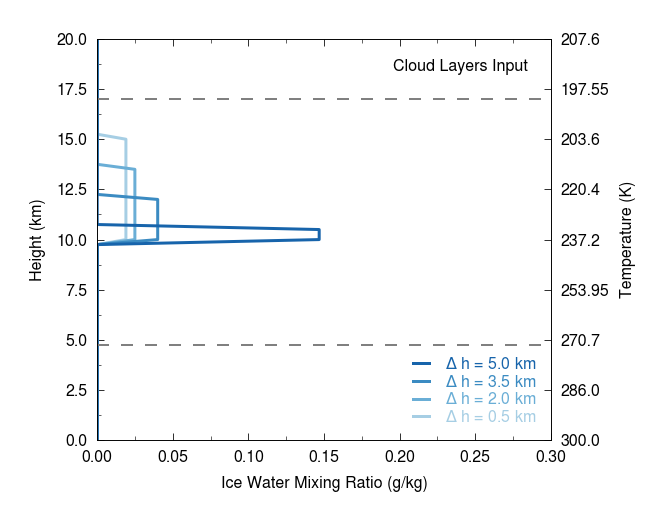

In [22]:
fontname  = 'Nimbus Sans'
fontsize  = 16
my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']
length    = 9 # inches
heigth    = length*.8 # inches
f, ax     = plt.subplots(figsize = (length, heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.15, right = 0.85)


handles = []
labels  = []
counter = 0
for i in [0,6,12,-1]:        
    h = ax.plot(q_ice[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                 linestyle = 'solid', linewidth = 3,
                 color = matplotlib.cm.Blues(.35 + counter*.15), alpha = 1)
    handles = handles + h
    labels.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    counter += 1

melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h5 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h6 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel('Ice Water Mixing Ratio (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-1,1,.05)
minor_ticks_x = np.arange(-1,1,.025)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .3)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
legend  = plt.legend(handles[::-1], labels[::-1], loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .1, labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size':fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_gdepth_top_v6.png', dpi = 500)

In [23]:
test = np.arange(0.1e-3,3.5001,0.1e-3)

In [25]:
len(test)

35000

#### Final Table

In [19]:
ds = xr.Dataset(
    data_vars = dict(
        #time = (time),
        depth = (['column'], geom_depths),
        #longitude = (['column'], longitude),
        lw_emissivity = (['column'], lw_emissivity),
        sw_albedo = (['column'], sw_albedo),
        skin_temperature = (['column'], skin_temperature),
        cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
        pressure_hl = (['column','half_level'], pressure_hl),
        temperature_hl = (['column','half_level'], temperature_hl),
        q = (['column','level'], q),
        o3_mmr = (['column','level'], o3_mmr),
        q_liquid = (['column','level'], q_liquid),
        q_ice = (['column','level'], q_ice),
        re_liquid = (['column','level'], re_liquid),
        re_ice = (['column','level'], re_ice),
        cloud_fraction = (['column','level'], cloud_fraction),
    ),
    attrs = dict(
        title="1D columns matrix input for ecRad"),
)

In [20]:
out_dir = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file    = 'input_1D_matrix_gdepth_bottom_v6.nc'
ds.to_netcdf(path = out_dir+file)